# EDA and Error Analysis on Scraped Twitter Data

This notebook performs:
1. Exploratory Data Analysis (EDA) on raw scraped Twitter data from Kompas and CekFakta.com.
2. Analysis of IndoHoaxDetector predictions on the data (HOAX rates, confidence, qualitative inspection).

Files:
- Raw data: `data/tweets_from_kompascom_20251106_124453.csv`, `data/tweets_from_cekfaktacom_20251105_144313.csv`
- Predictions: `prediction_results_tweets_from_kompascom_20251106_124453.csv` (run testing.ipynb if needed for CekFakta)

Assumptions:
- Columns: id, text, created_at, user, username, retweet_count, favorite_count, view_count, reply_count, quote_count, lang
- Predictions add: prediction (HOAX/FAKTA), confidence_score

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Set style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Paths
KOMPAS_RAW = 'data/tweets_from_kompascom_20251106_124453.csv'
CEKFAKTA_RAW = 'data/tweets_from_cekfaktacom_20251105_144313.csv'
KOMPAS_PRED = 'data/prediction_results_tweets_from_kompascom_20251106_124453.csv'
CEKFAKTA_PRED = 'data/prediction_results_tweets_from_cekfaktacom_20251105_144313.csv'

## 1. Load and Inspect Raw Data

In [10]:
# Load Kompas data
df_kompas = pd.read_csv(KOMPAS_RAW)
print(f"Kompas data shape: {df_kompas.shape}")
print("Kompas columns:", df_kompas.columns.tolist())
print("Kompas dtypes:")
print(df_kompas.dtypes)
print("\nSample rows:")
print(df_kompas.head())

# Load CekFakta data
df_cekfakta = pd.read_csv(CEKFAKTA_RAW)
print(f"\nCekFakta data shape: {df_cekfakta.shape}")
print("CekFakta columns:", df_cekfakta.columns.tolist())
print("CekFakta dtypes:")
print(df_cekfakta.dtypes)
print("\nSample rows:")
print(df_cekfakta.head())

Kompas data shape: (5000, 11)
Kompas columns: ['id', 'text', 'created_at', 'user', 'username', 'retweet_count', 'favorite_count', 'view_count', 'reply_count', 'quote_count', 'lang']
Kompas dtypes:
id                 int64
text              object
created_at        object
user              object
username          object
retweet_count      int64
favorite_count     int64
view_count         int64
reply_count        int64
quote_count        int64
lang              object
dtype: object

Sample rows:
                    id                                               text  \
0  1986283688972460183  Asosiasi Sepak Bola Malaysia (FAM) berpotensi ...   
1  1986281660158255211  Di balik ceritanya yang menusuk dan sinematogr...   
2  1986281407132672265  Presiden Meksiko Claudia Sheinbaum mengalami p...   
3  1986281320046338235  Berdasarkan Laporan Harta Kekayaan Penyelengga...   
4  1986279330906071392  Otoritas Portugal menangkap empat orang setela...   

                       created_at    

## 2. Basic Stats and Missing Values

In [11]:
# Missing values
print("Kompas missing values:")
print(df_kompas.isnull().sum())

print("\nCekFakta missing values:")
print(df_cekfakta.isnull().sum())

# Basic stats
print(f"\nKompas total tweets: {len(df_kompas)}")
print(f"CekFakta total tweets: {len(df_cekfakta)}")

# Date range
df_kompas['created_at'] = pd.to_datetime(df_kompas['created_at'], errors='coerce')
df_cekfakta['created_at'] = pd.to_datetime(df_cekfakta['created_at'], errors='coerce')

print(f"Kompas date range: {df_kompas['created_at'].min()} to {df_kompas['created_at'].max()}")
print(f"CekFakta date range: {df_cekfakta['created_at'].min()} to {df_cekfakta['created_at'].max()}")

# Unique users
print(f"Kompas unique users: {df_kompas['username'].nunique()}")
print(f"CekFakta unique users: {df_cekfakta['username'].nunique()}")

Kompas missing values:
id                0
text              0
created_at        0
user              0
username          0
retweet_count     0
favorite_count    0
view_count        0
reply_count       0
quote_count       0
lang              0
dtype: int64

CekFakta missing values:
id                   0
text                 0
created_at           0
user                 0
username             0
retweet_count        0
favorite_count       0
view_count        1463
reply_count          0
quote_count          0
lang                 0
dtype: int64

Kompas total tweets: 5000
CekFakta total tweets: 1990


C:\Users\Gareth\AppData\Local\Temp\ipykernel_31884\3067797248.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_kompas['created_at'] = pd.to_datetime(df_kompas['created_at'], errors='coerce')
C:\Users\Gareth\AppData\Local\Temp\ipykernel_31884\3067797248.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cekfakta['created_at'] = pd.to_datetime(df_cekfakta['created_at'], errors='coerce')


Kompas date range: 2025-10-08 13:32:31+00:00 to 2025-11-06 04:05:09+00:00
CekFakta date range: 2019-01-16 07:40:21+00:00 to 2025-09-11 06:42:53+00:00
Kompas unique users: 1
CekFakta unique users: 1


## 3. Text Analysis

Kompas text length stats:
count    5000.000000
mean      238.202000
std        69.247977
min        23.000000
25%       196.000000
50%       264.000000
75%       298.000000
max       308.000000
Name: text_length, dtype: float64

CekFakta text length stats:
count    1990.000000
mean      198.726131
std        70.397734
min        23.000000
25%       145.000000
50%       216.000000
75%       255.000000
max       325.000000
Name: text_length, dtype: float64


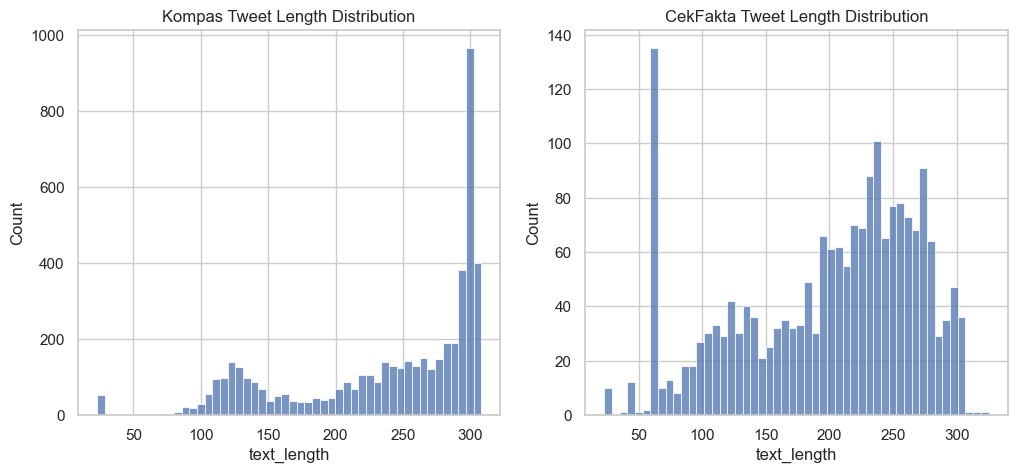

Kompas tweets with URLs: 4992 (99.84%)
CekFakta tweets with URLs: 1467 (73.72%)

Top 10 words in Kompas:
[('di', 4584), ('baca', 2792), ('yang', 2019), ('dan', 1843), ('sini', 1472), ('selengkapnya', 1208), ('untuk', 940), ('indonesia', 916), ('dari', 872), ('dalam', 759)]

Top 10 words in CekFakta:
[('di', 1567), ('yang', 1400), ('video', 738), ('dan', 682), ('cekfakta', 595), ('dengan', 576), ('tersebut', 566), ('faktanya', 564), ('selengkapnya', 525), ('periksafakta', 510)]


In [12]:
# Text lengths
df_kompas['text_length'] = df_kompas['text'].astype(str).apply(len)
df_cekfakta['text_length'] = df_cekfakta['text'].astype(str).apply(len)

print("Kompas text length stats:")
print(df_kompas['text_length'].describe())

print("\nCekFakta text length stats:")
print(df_cekfakta['text_length'].describe())

# Plot text lengths
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_kompas['text_length'], bins=50, ax=axes[0])
axes[0].set_title('Kompas Tweet Length Distribution')
sns.histplot(df_cekfakta['text_length'], bins=50, ax=axes[1])
axes[1].set_title('CekFakta Tweet Length Distribution')
plt.show()

# Presence of URLs
def has_url(text):
    return bool(re.search(r'http[s]?://', str(text)))

df_kompas['has_url'] = df_kompas['text'].apply(has_url)
df_cekfakta['has_url'] = df_cekfakta['text'].apply(has_url)

print(f"Kompas tweets with URLs: {df_kompas['has_url'].sum()} ({df_kompas['has_url'].mean():.2%})")
print(f"CekFakta tweets with URLs: {df_cekfakta['has_url'].sum()} ({df_cekfakta['has_url'].mean():.2%})")

# Top words (after basic cleaning)
def get_words(text):
    text = re.sub(r'http\S+', '', str(text).lower())
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()

kompas_words = Counter([word for text in df_kompas['text'] for word in get_words(text)])
cekfakta_words = Counter([word for text in df_cekfakta['text'] for word in get_words(text)])

print("\nTop 10 words in Kompas:")
print(kompas_words.most_common(10))

print("\nTop 10 words in CekFakta:")
print(cekfakta_words.most_common(10))

## 4. Engagement Metrics

Kompas engagement stats:
       retweet_count  favorite_count    view_count  reply_count  quote_count
count    5000.000000     5000.000000  5.000000e+03  5000.000000  5000.000000
mean       12.615400       41.125600  1.236291e+04    11.875000     5.572000
std        91.268035      218.361154  8.089810e+04    44.576931    42.090397
min         0.000000        0.000000  7.000000e+00     0.000000     0.000000
25%         0.000000        1.000000  1.578750e+03     0.000000     0.000000
50%         1.000000        4.000000  2.272000e+03     1.000000     0.000000
75%         4.000000       14.000000  4.876250e+03     5.000000     1.000000
max      4746.000000    10397.000000  3.134546e+06   834.000000  1834.000000

CekFakta engagement stats:
       retweet_count  favorite_count   view_count  reply_count  quote_count
count    1990.000000     1990.000000   527.000000  1990.000000  1990.000000
mean        1.506533        1.061809   524.937381     0.597487     0.060804
std         2.406984      

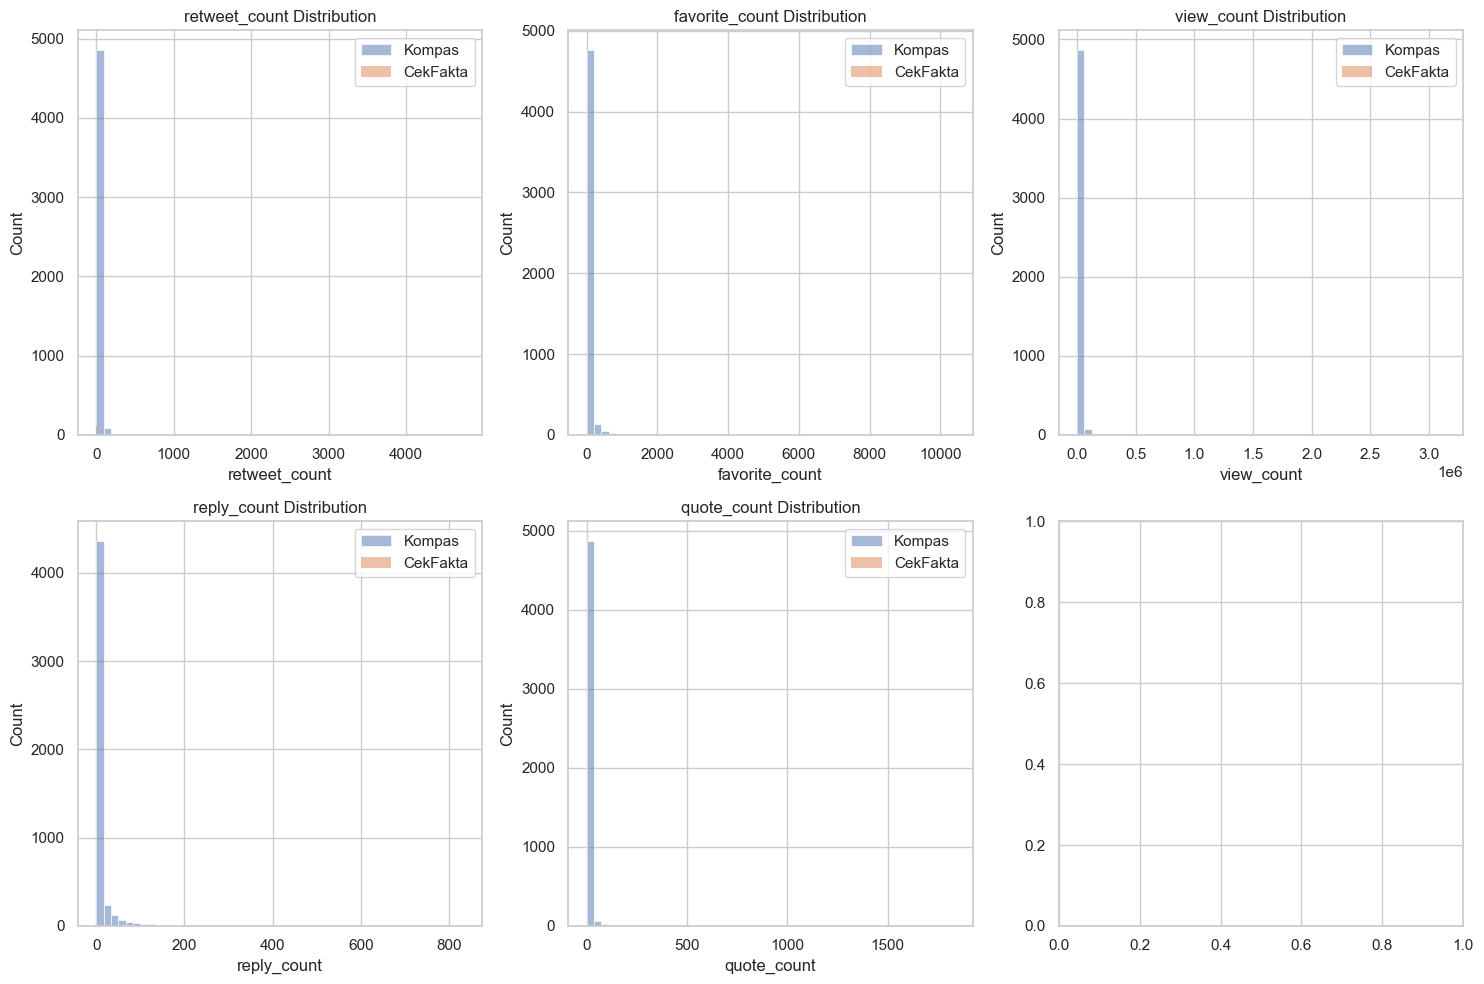

In [13]:
# Engagement stats
engagement_cols = ['retweet_count', 'favorite_count', 'view_count', 'reply_count', 'quote_count']

print("Kompas engagement stats:")
print(df_kompas[engagement_cols].describe())

print("\nCekFakta engagement stats:")
print(df_cekfakta[engagement_cols].describe())

# Plot engagement distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(engagement_cols):
    sns.histplot(df_kompas[col], bins=50, ax=axes[i], alpha=0.5, label='Kompas')
    sns.histplot(df_cekfakta[col], bins=50, ax=axes[i], alpha=0.5, label='CekFakta')
    axes[i].set_title(f'{col} Distribution')
    axes[i].legend()
plt.tight_layout()
plt.show()

## 5. Load and Analyze Prediction Results

Prediction data shape: (5000, 13)
Prediction columns: ['id', 'text', 'created_at', 'user', 'username', 'retweet_count', 'favorite_count', 'view_count', 'reply_count', 'quote_count', 'lang', 'prediction', 'confidence_score']

Sample predictions:
                                                text prediction  \
0  Asosiasi Sepak Bola Malaysia (FAM) berpotensi ...       HOAX   
1  Di balik ceritanya yang menusuk dan sinematogr...      FAKTA   
2  Presiden Meksiko Claudia Sheinbaum mengalami p...      FAKTA   
3  Berdasarkan Laporan Harta Kekayaan Penyelengga...      FAKTA   
4  Otoritas Portugal menangkap empat orang setela...       HOAX   

   confidence_score  
0          0.514507  
1          0.580468  
2          0.899029  
3          0.920609  
4          0.726242  

Overall HOAX rate: 39.12%


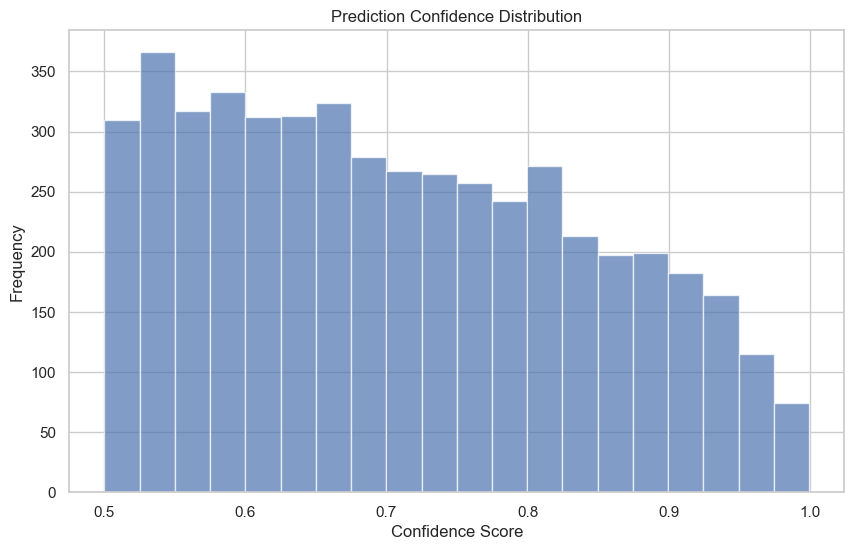

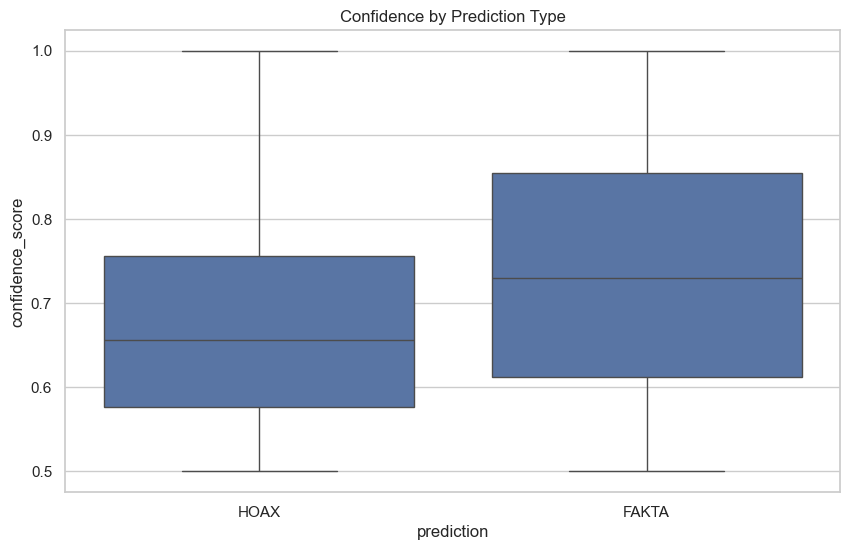

In [14]:
# Load prediction results (assuming Kompas predictions exist)
df_pred = pd.read_csv(KOMPAS_PRED)
print(f"Prediction data shape: {df_pred.shape}")
print("Prediction columns:", df_pred.columns.tolist())
print("\nSample predictions:")
print(df_pred[['text', 'prediction', 'confidence_score']].head())

# HOAX rate
hoax_rate = (df_pred['prediction'] == 'HOAX').mean()
print(f"\nOverall HOAX rate: {hoax_rate:.2%}")

# Confidence distribution
plt.hist(df_pred['confidence_score'], bins=20, alpha=0.7)
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.show()

# Confidence by prediction
sns.boxplot(x='prediction', y='confidence_score', data=df_pred)
plt.title('Confidence by Prediction Type')
plt.show()

## 6. Qualitative Inspection of Predictions

In [15]:
# High-confidence HOAX
high_conf_hoax = df_pred[(df_pred['prediction'] == 'HOAX') & (df_pred['confidence_score'] > 0.8)]
print(f"High-confidence HOAX examples ({len(high_conf_hoax)}):")
for _, row in high_conf_hoax.head(5).iterrows():
    print(f"- Conf: {row['confidence_score']:.3f} :: {row['text'][:200]}...")

# High-confidence FAKTA
high_conf_fakta = df_pred[(df_pred['prediction'] == 'FAKTA') & (df_pred['confidence_score'] > 0.8)]
print(f"\nHigh-confidence FAKTA examples ({len(high_conf_fakta)}):")
for _, row in high_conf_fakta.head(5).iterrows():
    print(f"- Conf: {row['confidence_score']:.3f} :: {row['text'][:200]}...")

# Low-confidence predictions
low_conf = df_pred[df_pred['confidence_score'] < 0.6]
print(f"\nLow-confidence examples ({len(low_conf)}):")
for _, row in low_conf.head(5).iterrows():
    print(f"- Pred: {row['prediction']}, Conf: {row['confidence_score']:.3f} :: {row['text'][:200]}...")

High-confidence HOAX examples (312):
- Conf: 0.882 :: Viral, Ortu Ngamuk ke Guru Usai Anak Ditampar karena Lompati Pagar https://t.co/KiUPVMwTAx...
- Conf: 0.852 :: Federasi Sepak Bola Dunia (FIFA) mengumumkan peluncuran penghargaan baru bertajuk FIFA Peace Prize atau Penghargaan Perdamaian FIFA.

Baca selengkapnya: https://t.co/EMeMmlnhQ2 

~RS  #FIFA #PeacePriz...
- Conf: 0.894 :: Pelaku Penguburan Bayi di Banyuwangi Ngaku Sembunyikan Kehamilan dari Suami

~AM #Banyuwangi #Bayi 
https://t.co/omHbV7ouVn...
- Conf: 0.912 :: Istirahat di Masjid Tak Salah, Jangan Lagi Ada yang Mati Karena Itu https://t.co/mlIoj34u7g...
- Conf: 0.811 :: https://t.co/FzH0Nmt5Oz...

High-confidence FAKTA examples (1099):
- Conf: 0.899 :: Presiden Meksiko Claudia Sheinbaum mengalami pelecehan saat berjalan kaki dari Istana Nasional menuju Kementerian Pendidikan, Rabu (5/11/2025). 

Dalam video yang viral, seorang pria melakukan peleceh...
- Conf: 0.921 :: Berdasarkan Laporan Harta Kekayaan Penyelenggara Nega

## 7. Summary and Insights

- **EDA Findings**: Summarize data quality, differences between sources, text patterns.
- **Prediction Analysis**: HOAX rates, confidence trends, potential biases (e.g., over-flagging news-like content).
- **Error Patterns**: Document qualitative examples for report.

Use these insights to populate the deployment case study and error analysis sections in your IndoHoaxDetector report.